In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
from NFLUtils import NFLUtils
import optuna
%matplotlib inline
nfl_utils = NFLUtils()

# ANN
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

# Set device to GPU if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load CSV
cp Combined.csv ~/drive/Notes/ML/Pytorch/footballData/n

In [3]:
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)

# Shuffle dataFrame (don't do this?)
# df = shuffle(df, random_state=101)
# df.head()
df.info()

test_performance_size = 200
test_performance_df = df[df.shape[0]-test_performance_size:]
df = df[:df.shape[0]-test_performance_size]
print(f'df after perf set removed: {df.shape}')
print(f'df perf set size {test_performance_df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5533 entries, 0 to 5532
Columns: 209 entries, Unnamed: 0 to D_datediff
dtypes: float64(133), int64(67), object(9)
memory usage: 8.8+ MB
df after perf set removed: (5333, 209)
df perf set size (200, 209)


### Remove items from performance set where you have no odds data

In [4]:
# test_performance_df = test_performance_df.loc[test_performance_df['D_start_odds']!= 0]
# test_performance_size = test_performance_df.shape[0]
# test_performance_df.tail()

# Columns to use
(TODO)

In [5]:
df[:5]

,Unnamed: 0,Season,Date,Home_Team,H_Q1,H_Q2,H_Q3,H_Q4,H_OT,H_Final,...,D_punting_lng,D_punting_pnt,D_punting_yds,D_scoring_fga,D_scoring_fgm,D_scoring_xpa,D_scoring_xpm,D_start_odds,D_halftime_odds,D_datediff
0,229,1995,1995-10-08,ARI,3,7,11,0,0,21,...,6.576,-0.752,-25.640,1.424,1.024,-1.528,-1.528,0.0,0.0,0.0
1,232,1995,1995-10-08,CIN,3,3,3,7,0,16,...,3.936,0.392,19.296,1.224,0.744,1.520,1.520,0.0,0.0,0.0
2,234,1995,1995-10-08,PIT,0,7,6,3,0,16,...,-11.256,-5.080,-237.168,2.176,1.376,-0.080,-0.080,0.0,0.0,0.0
3,228,1995,1995-10-08,WAS,10,7,7,10,0,34,...,-0.952,-1.120,-67.480,0.784,0.784,-0.488,-0.488,0.0,0.0,0.0
4,223,1995,1995-10-09,LAC,3,10,0,10,0,23,...,2.944,-1.304,-81.712,-0.904,-0.480,-0.408,-0.408,0.0,0.0,0.0


## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [6]:
cat_cols = []
cont_cols = [
    # Home vs away days since last game
    'H_datediff', 'V_datediff',
    
    # First Downs
    'H_First_Downs', 'V_First_Downs',
    
    # Basic Stats
    'H_Rush', 'V_Rush',
    'H_Yds', 'V_Yds',
    'H_TDs', 'V_TDs',
    'H_Cmp', 'V_Cmp',
    'H_Att', 'V_Att',
    'H_Yd', 'V_Yd',
    'H_TD', 'V_TD',
    'H_INT', 'V_INT',
    'H_Sacked', 'V_Sacked',
    'H_Yards', 'V_Yards',
    'H_Net_Pass_Yards', 'V_Net_Pass_Yards',
    'H_Total_Yards', 'V_Total_Yards',
    'H_Fumbles', 'V_Fumbles',
    'H_Lost', 'V_Lost',
    'H_Turnovers', 'V_Turnovers',
    'H_Penalties', 'V_Penalties',
    #'H_Third_Down_Conv', 'V_Third_Down_Conv',
    #'H_Fourth_Down_Conv', 'V_Fourth_Down_Conv',
    #'H_Time_of_Possession', 'V_Time_of_Possession',
    
    # Passing Detailed
    'H_passing_att', 'V_passing_att',
    'H_passing_cmp', 'V_passing_cmp',
    'H_passing_int', 'V_passing_int',
    'H_passing_lng', 'V_passing_lng',
    'H_passing_sk', 'V_passing_sk',
    'H_passing_td', 'V_passing_td',
    'H_passing_yds', 'V_passing_yds',
    
    # Receiving
    'H_receiving_lng', 'V_receiving_lng',
    'H_receiving_td', 'V_receiving_td',
    'H_receiving_yds', 'V_receiving_yds',
    
    # Rushing Detailed
    'H_rushing_att', 'V_rushing_att',
    'H_rushing_lng', 'V_rushing_lng',
    'H_rushing_td', 'V_rushing_td',
    'H_rushing_yds', 'V_rushing_yds',
    
    # Defense Interceptions
    'H_def_interceptions_int', 'V_def_interceptions_int',
    'H_def_interceptions_lng', 'V_def_interceptions_lng',
    # 'H_def_interceptions_pd', 'V_def_interceptions_pd',
    'H_def_interceptions_td', 'V_def_interceptions_td',
    'H_def_interceptions_yds', 'V_def_interceptions_yds',
    
    # Defense Fumbles
    'H_fumbles_ff', 'V_fumbles_ff',
    'H_fumbles_fr', 'V_fumbles_fr',
    'H_fumbles_td', 'V_fumbles_td',
    'H_fumbles_yds', 'V_fumbles_yds',
    
    # Defense Tackles
    'H_sk', 'V_sk',
    'H_tackles_ast', 'V_tackles_ast',
    'H_tackles_comb', 'V_tackles_comb',
    # 'H_tackles_qbhits', 'V_tackles_qbhits',
    'H_tackles_solo', 'V_tackles_solo',
    # 'H_tackles_tfl', 'V_tackles_tfl',
    
    # Kick Returns
    'H_kick_returns_lng', 'V_kick_returns_lng',
    'H_kick_returns_rt', 'V_kick_returns_rt',
    'H_kick_returns_td', 'V_kick_returns_td',
    'H_kick_returns_yds', 'V_kick_returns_yds',
    
    # Punt Returns
    'H_punt_returns_lng', 'V_punt_returns_lng',
    'H_punt_returns_ret', 'V_punt_returns_ret',
    'H_punt_returns_td', 'V_punt_returns_td',
    'H_punt_returns_yds', 'V_punt_returns_yds',
    
    # Punting/Scoring
    'H_punting_lng', 'V_punting_lng',
    'H_punting_pnt', 'V_punting_pnt',
    'H_punting_yds', 'V_punting_yds',
    'H_scoring_fga', 'V_scoring_fga',
    'H_scoring_fgm', 'V_scoring_fgm',
    'H_scoring_xpa', 'V_scoring_xpa',
    'H_scoring_xpm', 'V_scoring_xpm',
    
    # Odds
    # 'H_start_odds', 'V_start_odds',
    # 'H_halftime_odds', 'V_halftime_odds'
]

cont_cols = [
    'D_datediff', # Days since last game (Home - visitor)
    
    # first downs
    'D_First_Downs',
    
    # Basic Stats
    'D_Rush',
    'D_Yds',
    'D_TDs',
    'D_Cmp',
    'D_Att',
    'D_Yd',
    'D_TD',
    'D_INT',
    'D_Sacked',
    'D_Yards',
    'D_Net_Pass_Yards',
    'D_Total_Yards',
    'D_Fumbles',
    'D_Lost',
    'D_Turnovers',
    'D_Penalties',
    
    # Passing Detailed
    'D_passing_att',
    'D_passing_cmp',
    'D_passing_int',
    'D_passing_lng',
    'D_passing_sk',
    'D_passing_td',
    'D_passing_yds',
    
    # Receiving
    'D_receiving_lng',
    'D_receiving_td',
    'D_receiving_yds',
    
    # Rushing Detailed
    'D_rushing_att',
    'D_rushing_lng',
    'D_rushing_td',
    'D_rushing_yds',
    
    # Defense interceptions
    'D_def_interceptions_int',
    'D_def_interceptions_lng',
    # 'D_def_interceptions_pd',
    'D_def_interceptions_td',
    'D_def_interceptions_yds',
    
    # Defense fumbles
    'D_fumbles_ff',
    'D_fumbles_fr',
    'D_fumbles_td',
    'D_fumbles_yds',
    
    # Defense tackles
    'D_sk',
    'D_tackles_ast',
    'D_tackles_comb',
    # 'D_tackles_qbhits',
    'D_tackles_solo',
    # 'D_tackles_tfl',
    
    # Kick Returns
    'D_kick_returns_lng',
    'D_kick_returns_rt',
    'D_kick_returns_td',
    'D_kick_returns_yds',
    
    # Punt Returns
    'D_punt_returns_lng',
    'D_punt_returns_ret',
    'D_punt_returns_td',
    'D_punt_returns_yds',
    
    # Punting / Scoring
    'D_punting_lng',
    'D_punting_pnt',
    'D_punting_yds',
    'D_scoring_fga',
    'D_scoring_fgm',
    'D_scoring_xpa',
    'D_scoring_xpm'
]


y_col = ['H_Won']
y_col_perf = ['H_Won', 'H_start_odds', 'V_start_odds', 'H_halftime_odds', 'V_halftime_odds']


# create cont_df and y_df from the df
print(df.shape)
cont_df = df[cont_cols]
y_df = df[y_col]

# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col_perf]
perf_date_df = test_performance_df[['Date','Home_Team', 'Visitor_Team']]

# print(cont_df.dtypes)
print(cont_df.shape)
print(perf_y_df.shape)
print(perf_y_df.tail())
print(perf_conts_df.tail())


(5333, 209)
(5333, 59)
(200, 5)
      H_Won  H_start_odds  V_start_odds  H_halftime_odds  V_halftime_odds
5528    0.0         1.622         2.364              0.0              0.0
5529    0.0         3.173         1.377              0.0              0.0
5530    0.0         4.470         1.221              0.0              0.0
5531    1.0         2.369         1.619              0.0              0.0
5532    0.0         1.701         2.202              0.0              0.0
      D_datediff  D_First_Downs  D_Rush  D_Yds  D_TDs  D_Cmp  D_Att  D_Yd  \
5528         0.0              8     -38     -1     13      5     51    -2   
5529         0.0             -1     -45    -14     13     -1     79    -4   
5530         0.0             -4     -46    -17     57      1     81    -7   
5531         0.0             -2      78      7      0      2    -98     6   
5532         0.0              7       8      4    -20     -1     11     9   

      D_TD  D_INT  ...  D_punt_returns_ret  D_punt_returns_td

## Monotone constraints dict

In [7]:
monotone_constraints = {
    # Time between games - More rest is better
    'D_datediff': 1,
    
    # Offensive positive indicators
    'D_First_Downs': 1,
    'D_Rush': 1,
    'D_Yds': 1,
    'D_TDs': 1,
    'D_Cmp': 1,
    'D_Yd': 1,
    'D_TD': 1,
    'D_Net_Pass_Yards': 1,
    'D_Total_Yards': 1,
    
    # Negative indicators
    'D_INT': -1,
    'D_Sacked': -1,
    'D_Fumbles': -1,
    'D_Lost': -1,
    'D_Turnovers': -1,
    'D_Penalties': -1,
    
    # Passing detail - positive
    'D_passing_cmp': 1,
    'D_passing_td': 1,
    'D_passing_yds': 1,
    'D_passing_lng': 1,
    
    # Passing detail - negative
    'D_passing_int': -1,
    'D_passing_sk': -1,
    
    # Receiving/Rushing - all positive
    'D_receiving_td': 1,
    'D_receiving_yds': 1,
    'D_receiving_lng': 1,
    'D_rushing_td': 1,
    'D_rushing_yds': 1,
    'D_rushing_lng': 1,
    
    # Defense - generally positive when in your favor
    'D_def_interceptions_int': 1,
    'D_def_interceptions_td': 1,
    'D_def_interceptions_yds': 1,
    'D_fumbles_fr': 1,
    'D_fumbles_td': 1,
    'D_sk': 1,
    # 'D_tackles_qbhits': 1,
    # 'D_tackles_tfl': 1,
    
    # Special teams - positive indicators
    'D_kick_returns_td': 1,
    'D_kick_returns_yds': 1,
    'D_punt_returns_td': 1,
    'D_punt_returns_yds': 1,
    
    # Scoring - positive
    'D_scoring_fgm': 1,
    'D_scoring_xpm': 1
}

monotone_constraints_tuple = ()
no_monotone_constraints_tuple = ()
for col in cont_cols:
    monotone_constraints_tuple = monotone_constraints_tuple + (monotone_constraints[col],) if col in monotone_constraints else monotone_constraints_tuple + (0,)
    no_monotone_constraints_tuple = no_monotone_constraints_tuple + (0,)
print(monotone_constraints_tuple)
print(no_monotone_constraints_tuple)

(1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


#### 1a. Normalize cont_df
StandardScaler is instead used by the pipeline

In [8]:
# min_max_scaler = preprocessing.MinMaxScaler()
# cont_scaled = min_max_scaler.fit_transform(cont_df.values)
# cont_df = pd.DataFrame(cont_scaled)
# cont_df.head()

# # test performance set
# perf_conts_df_scaled = min_max_scaler.fit_transform(perf_conts_df.values)
# perf_conts_df = pd.DataFrame(perf_conts_df_scaled)

### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [9]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)
perf_date_col = np.stack([perf_date_df[col].values for col in list(perf_date_df.columns)], 1)


conts_train = conts
y_train = y_col

### 4. Convert conts to tensor

In [10]:
print(conts.shape)
print(y_col.shape)

(5333, 59)
(5333, 1)


In [11]:
# Handled by model.fit()
# conts = torch.tensor(conts, dtype=torch.float32)
# y_col = torch.tensor(y_col, dtype=torch.float32)

In [12]:
class TabularModel(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, criterion=nn.BCELoss(),
                optimizer_class=torch.optim.Adam, lr=0.001, n_epochs=10, confidence_threshold=0.1):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr
        
        # Training params
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.n_epochs = n_epochs
        self.confidence_threshold = confidence_threshold
        
        # BatchNorm layer for continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(self.layer_shape[-1], out_sz),
            # nn.Sigmoid()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cont):
        x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return x
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        
        # Initialize optimizer
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        
        # Training loop
        self.train()
        for _ in range(self.n_epochs):
            optimizer.zero_grad()
            y_pred = self.forward(X)
            loss = self.criterion(y_pred, y)
            loss.backward()
            optimizer.step()

        return self
    
    def predict(self, X):
        probas = self.predict_proba(X)
        # return (probas > 0.5).astype(int)
        return probas
    
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)
            return self(X).numpy()
    
    def score(self, X, y):
        """        
        12/5 - this isn't called at all if 'scoring' is defined
        """
        probas = self.predict_proba(X)
        # First apply confidence thresholding
        mask = (probas < 0.5 - self.confidence_threshold) | (probas > 0.5 + self.confidence_threshold)
        predictions = np.where(mask, (probas > 0.5).astype(np.int32), np.nan)

        # Use numpy mask for nan values
        valid_mask = ~np.isnan(predictions)
        valid_predictions = predictions[valid_mask]
        valid_targets = y[valid_mask]
        
        # Apply f1 score
        score = f1_score(valid_predictions.flatten(), valid_targets)
        return np.mean(score)

In [13]:
class TabularModelUpdated(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, criterion=nn.MSELoss(),
                optimizer_class=torch.optim.Adam, lr=0.001, confidence_threshold=0.1):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr
        
        # Training params
        self.criterion = criterion
        self.confidence_threshold = confidence_threshold
        
        # BatchNorm layer for continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(self.layer_shape[-1], out_sz),
            # nn.Sigmoid()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        # Initialize the optimizer
        self.optimizer = optimizer_class(self.parameters(), lr=self.lr)

        
    def forward(self, x_cont):
        x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return x
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        
        # Initialize optimizer
        # optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        # Training loop
        self.train()
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return self
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas > 0.5).astype(int)
        # return probas
    
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)
            return self(X).numpy()
    
    def score(self, X, y):
        """        
        12/5 - this isn't called at all if 'scoring' is defined
        """
        probas = self.predict_proba(X)
        # First apply confidence thresholding
        mask = (probas < 0.5 - self.confidence_threshold) | (probas > 0.5 + self.confidence_threshold)
        predictions = np.where(mask, (probas > 0.5).astype(np.int32), np.nan)

        # Use numpy mask for nan values
        valid_mask = ~np.isnan(predictions)
        valid_predictions = predictions[valid_mask]
        valid_targets = y[valid_mask]
        
        # Penalize if < 80% predicted
        if (1.0* len(valid_predictions) / len(X)) < 0.85:
            # print(f"mask {len(valid_predictions)}  pred {len(X)}")
            return 0.0

        # Apply f1 score
        score = f1_score(valid_predictions.flatten(), valid_targets)
        return score

In [14]:
def objective(trial):
    # --- Suggest hyperparameters ---

    criterion = trial.suggest_categorical('criterion', nfl_utils.map_losses(None).keys())
    first_layer_size = trial.suggest_categorical('first_layer_size', [64, 56, 48, 32, 16, 12])
    min_layers = math.floor(math.sqrt(first_layer_size))
    num_layers = trial.suggest_int('num_layers', 2, min_layers)
    confidence_threshold = trial.suggest_float('confidence_threshold', 0, 0.05)
    layer_shape = [first_layer_size]
    for i in range(1, num_layers):
        layer_shape.append(first_layer_size//(2*i))
    
    # Set random state to have consistent results (42 is arbitrary)
    set_all_seeds()
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=False)

    # Split once
    X_train_fold = []
    X_val = []
    y_train_fold = []
    y_val = []
    models = []
    for train_index, val_index in kf.split(conts_train):
        # print(f"train {train_index.shape} val {val_index.shape}")
        X_train_fold.append(torch.FloatTensor(conts_train[train_index]).to(device))
        X_val.append(torch.FloatTensor(conts_train[val_index]).to(device))

        y_train_fold.append(torch.FloatTensor(y_train[train_index]).to(device))
        y_val.append(torch.FloatTensor(y_train[val_index]).to(device))

        model = TabularModelUpdated(
            n_cont=conts.shape[1],
            out_sz=1,
            layer_shape=layer_shape,
            p=trial.suggest_float('dropout', 0.28, 0.38),     # Dropout
            criterion=nfl_utils.map_losses(criterion),
            optimizer_class=torch.optim.Adam,
            lr=trial.suggest_float('lr', 1e-3, 1e-2, log=True),   # Learning rate 
            confidence_threshold=confidence_threshold
        )
        pipeline = Pipeline([
            ('scaler', StandardScaler()), # Standardize the numerical features
            # ('regressor', LinearRegression()), # Apply a regression model
            ('model', model)
        ])
        models.append(pipeline)

    # Run once on each split, track average loss, stop if > max patience
    max_patience = 10
    current_patience = max_patience
    tracked_loss = 0.0
    n_epochs = 0
    while current_patience > 0 or n_epochs < 100:
        n_epochs = n_epochs + 1
        running_loss = []
        for i in range(0,n_splits):
            # ----- Train -----
            models[i].fit(X_train_fold[i], y_train_fold[i])

            # ----- Eval -----
            running_loss.append(models[i].score(X_val[i], y_val[i]))
            # y_pred = models[i].predict(X_val[i])
            # running_loss.append(f1_score(y_val[i], y_pred))
        running_loss = np.mean(running_loss)

        # ----- Current epoch loss > previous -----
        # print(f"{tracked_loss} {running_loss} {tracked_loss < running_loss}")
        if tracked_loss < running_loss:
            current_patience = max_patience
            tracked_loss = running_loss
        else:
            current_patience = current_patience - 1
    trial.suggest_int('n_epochs', n_epochs, n_epochs)
    trial.report(tracked_loss, n_epochs)
    return tracked_loss

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")

In [15]:
study = optuna.create_study(
    direction='maximize',   # max because using f1
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=1000
    )
)
# Uncomment to run
if True:
    study.optimize(objective, n_trials=2000, callbacks=[print_callback])
    # study.optimize(objective, n_trials=3)
    print("Best trial:")
    trial = study.best_trial
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2025-01-14 10:05:40,452] A new study created in memory with name: no-name-ed59f111-95cb-43fb-bf26-8896707b4ad2
[I 2025-01-14 10:05:46,438] Trial 0 finished with value: 0.0 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.023774481008761353, 'dropout': 0.2815631616933799, 'lr': 0.0018227142905140393, 'n_epochs': 100}. Best is trial 0 with value: 0.0.


Trial 0 finished with value: 0.0
Best trial so far: 0, value: 0.0


[I 2025-01-14 10:05:51,223] Trial 1 finished with value: 0.4559828058043684 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.02240661266725044, 'dropout': 0.31419688289222003, 'lr': 0.009201099527876523, 'n_epochs': 100}. Best is trial 1 with value: 0.4559828058043684.


Trial 1 finished with value: 0.4559828058043684
Best trial so far: 1, value: 0.4559828058043684


[W 2025-01-14 10:05:53,646] Trial 2 failed with parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.005973481239590695, 'dropout': 0.284747402551489, 'lr': 0.0027029354763241854} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_3860/1515200931.py", line 60, in objective
    models[i].fit(X_train_fold[i], y_train_fold[i])
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/Users/forbesjon2/anaconda

KeyboardInterrupt: 

In [ ]:
# best_params = study.best_trial.params
best_params = {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}
layer_shape = [best_params['first_layer_size']]
for i in range(1, best_params['num_layers']):
    layer_shape.append(best_params['first_layer_size']//(2*i))

# Set random state to have consistent results (42 is arbitrary)
set_all_seeds()
model = TabularModelUpdated(
    n_cont=conts.shape[1],
    out_sz=1,
    layer_shape=layer_shape,
    p=best_params['dropout'],     # Dropout
    criterion=nfl_utils.map_losses(best_params['criterion']),
    optimizer_class=torch.optim.Adam,
    lr= best_params['lr'],   # Learning rate 
    confidence_threshold=best_params['confidence_threshold']
)


pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize the numerical features
    # ('regressor', LinearRegression()), # Apply a regression model
    ('model', model)
])

# Run once on each split, track average loss, stop if > max patience
for _ in range(0, (best_params['n_epochs'] - 10)):
    running_loss = 0.0
    # ----- Train -----
    pipeline.fit(conts_train, y_train)

    # ----- Eval -----
    # loss = pipeline.score(perf_conts, perf_y_col)
    #print(f"loss: {loss}")

# pipeline.fit(conts_train, y_train)
probas = pipeline.predict(perf_conts)
confidence_threshold = best_params['confidence_threshold']


Value:  0.37491718013436764

Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 39
    dropout: 0.47875406200808335
    lr: 0.009997751942238913
    


Value:  0.3759073484440955
Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 68
    dropout: 0.4497689844977892
    lr: 0.007977206154472633
    
    
    
12/6

Trial 206 finished with value: 0.547218605316966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.05966702820817666, 'n_epochs': 379, 'dropout': 0.36961850006275193, 'lr': 0.008649806179332952}. Best is trial 206 with value: 0.547218605316966.

[I 2024-12-06 12:49:28,047] Trial 579 finished with value: 0.5335308702482566 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.059979796814548306, 'n_epochs': 481, 'dropout': 0.2511747953677191, 'lr': 0.007942836869449217}. Best is trial 579 with value: 0.5335308702482566.


[I 2024-12-06 14:53:00,850] Trial 385 finished with value: 0.5547767877242975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.003263372268063613, 'n_epochs': 300, 'dropout': 0.3153661030384182, 'lr': 0.00593138298730814}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:32:38,969] Trial 583 finished with value: 0.550872165273167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.010458110701511005, 'n_epochs': 336, 'dropout': 0.3188974735143638, 'lr': 0.006976522077116529}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:55:26,133] Trial 669 finished with value: 0.5645423555160363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0243907527056759, 'n_epochs': 370, 'dropout': 0.32998724447261185, 'lr': 0.0075018456671685696}. Best is trial 669 with value: 0.5645423555160363.

[I 2024-12-06 20:33:46,555] Trial 1737 finished with value: 0.5716002919237433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}. Best is trial 1737 with value: 0.5716002919237433.


[I 2024-12-06 21:17:06,545] Trial 1889 finished with value: 0.5739803740995499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.014029751567812504, 'n_epochs': 357, 'dropout': 0.34275064196127053, 'lr': 0.008692336113071646}. Best is trial 1889 with value: 0.5739803740995499.

[I 2024-12-10 09:39:54,796] Trial 1612 finished with value: 0.5748324966932515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003855147984840053, 'dropout': 0.3182765851196762, 'lr': 0.008210651343970551, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.



Trial 1749 finished with value: 0.5772962775717783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}.




In [ ]:
nfl_utils.backtest_model(pipeline, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.05, confidence_threshold=best_params['confidence_threshold'], show_plot=True)


In [ ]:
# Remove outside of confidence threshold
mask = (probas < 0.5 - confidence_threshold) | (probas > 0.5 + confidence_threshold)
predictions = np.where(mask, probas, np.nan)

# Use numpy mask for nan values
valid_mask = ~np.isnan(predictions)
valid_predictions = predictions[valid_mask]
valid_mask = valid_mask.flatten()
perf_y_col_mask = perf_y_col[valid_mask]


true_values = perf_y_col_mask[:,0].astype(np.int32)
pred_values = valid_predictions.flatten()
pred_values_int = np.rint(valid_predictions).flatten().astype(np.int32)

model_win_prob = (1.0*(true_values == pred_values_int).sum()) / (true_values.shape[0])
print(model_win_prob)

# Using XGBoost

In [ ]:
conts_train.shape

In [ ]:
# Fit the model
param_grid = {
    'learning_rate': [ 0.008, 0.01, 0.03],           # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
    # 'monotone_constraints': [monotone_constraints_tuple, no_monotone_constraints_tuple]
    'monotone_constraints': [no_monotone_constraints_tuple]
}
param_grid = {
    'learning_rate': [0.005, 0.01, 0.05],        # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3],                         # Simplified to 3 values, covering shallow to deep
    'n_estimators': [300, 350, 400],             # Removed extremes, these are most common sweet spots
    'subsample': [0.5, 0.6, 0.7],                # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.5, 0.6, 0.7],         # Same as above
    'min_child_weight': [3, 4],                  # Removed 5 as it might be too restrictive
    'monotone_constraints': [monotone_constraints_tuple, no_monotone_constraints_tuple]
}

# model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = XGBRegressor(objective='reg:squarederror')

# Create a custom scorer using the F1 score
# f1_scorer = make_scorer(f1_score, average='weighted')
# Tune hyperparameters using GridSearchCV with the custom F1 scorer
# grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5, verbose=1)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(conts_train, y_train)


In [ ]:
print(grid_search.best_params_)
# No monotone constraints
# 60.15%, {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
# 65% {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

# Monotone constraints
# {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 200, 'subsample': 1.0}

In [16]:

# train final model w/ early stopping
model = XGBClassifier(
    eval_metric='logloss',
    early_stopping_rounds=10,
    # **grid_search.best_params_
    # **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # **{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 90, 'subsample': 1.0},
    
    # **{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 200, 'subsample': 1.0}

    # **grid_search.best_params_,
    # **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'monotone_constraints': (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 31.4%
    # {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 30.9%
    # {'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 3, 'monotone_constraints': (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'n_estimators': 300, 'subsample': 0.6}
)
model = XGBRegressor(
    objective='reg:squarederror', 
    # **grid_search.best_params_,
    # 67.3 w/ kelly adjustments 0.2, 0.01
    # {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'monotone_constraints': (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'n_estimators': 350, 'subsample': 0.6}
    # 67.2, dd 28.68 kelly 0.25, 0.014
    **{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'n_estimators': 350, 'subsample': 0.5}
)
model.fit(
    conts_train,
    y_train,
    eval_set=[(conts_train, y_train)], # , (holdout_conts, holdout_y)
    verbose=True
)

[0]	validation_0-rmse:0.49958
[1]	validation_0-rmse:0.49919
[2]	validation_0-rmse:0.49876
[3]	validation_0-rmse:0.49838
[4]	validation_0-rmse:0.49801
[5]	validation_0-rmse:0.49762
[6]	validation_0-rmse:0.49724
[7]	validation_0-rmse:0.49685
[8]	validation_0-rmse:0.49648
[9]	validation_0-rmse:0.49613
[10]	validation_0-rmse:0.49576
[11]	validation_0-rmse:0.49539
[12]	validation_0-rmse:0.49505
[13]	validation_0-rmse:0.49469
[14]	validation_0-rmse:0.49431
[15]	validation_0-rmse:0.49393
[16]	validation_0-rmse:0.49360
[17]	validation_0-rmse:0.49324
[18]	validation_0-rmse:0.49294
[19]	validation_0-rmse:0.49262
[20]	validation_0-rmse:0.49229
[21]	validation_0-rmse:0.49197
[22]	validation_0-rmse:0.49171
[23]	validation_0-rmse:0.49139
[24]	validation_0-rmse:0.49110
[25]	validation_0-rmse:0.49081
[26]	validation_0-rmse:0.49052
[27]	validation_0-rmse:0.49020
[28]	validation_0-rmse:0.48994
[29]	validation_0-rmse:0.48964
[30]	validation_0-rmse:0.48935
[31]	validation_0-rmse:0.48911
[32]	validation_0-

[260]	validation_0-rmse:0.46363
[261]	validation_0-rmse:0.46358
[262]	validation_0-rmse:0.46351
[263]	validation_0-rmse:0.46346
[264]	validation_0-rmse:0.46339
[265]	validation_0-rmse:0.46331
[266]	validation_0-rmse:0.46327
[267]	validation_0-rmse:0.46322
[268]	validation_0-rmse:0.46315
[269]	validation_0-rmse:0.46311
[270]	validation_0-rmse:0.46308
[271]	validation_0-rmse:0.46301
[272]	validation_0-rmse:0.46295
[273]	validation_0-rmse:0.46289
[274]	validation_0-rmse:0.46283
[275]	validation_0-rmse:0.46276
[276]	validation_0-rmse:0.46271
[277]	validation_0-rmse:0.46268
[278]	validation_0-rmse:0.46265
[279]	validation_0-rmse:0.46259
[280]	validation_0-rmse:0.46253
[281]	validation_0-rmse:0.46248
[282]	validation_0-rmse:0.46242
[283]	validation_0-rmse:0.46236
[284]	validation_0-rmse:0.46232
[285]	validation_0-rmse:0.46226
[286]	validation_0-rmse:0.46219
[287]	validation_0-rmse:0.46214
[288]	validation_0-rmse:0.46211
[289]	validation_0-rmse:0.46207
[290]	validation_0-rmse:0.46202
[291]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan,
             monotone_constraints=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...),
             n_estimators=350, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [17]:
# perf_conts.shape
perf_y_col.shape
perf_y_col[0]

array([0.        , 3.35714286, 1.34642857, 2.355     , 1.5675    ])

['2024-10-14' 'BUF' 'NYJ']
2024-10-14: w_odds:1.33 acct_val: 1000.00 usable cash: 900.00 won: True
2024-10-14: w_odds:1.46 acct_val: 1033.30 usable cash: 796.67 won: True
2024-10-14: w_odds:2.04 acct_val: 1080.42 usable cash: 688.63 won: True
2024-10-14: w_odds:1.54 acct_val: 1192.57 usable cash: 569.37 won: True
2024-10-14: w_odds:1.37 acct_val: 1257.32 usable cash: 443.64 won: False
2024-10-14: w_odds:1.40 acct_val: 1131.59 usable cash: 330.48 won: True
2024-10-14: w_odds:1.31 acct_val: 1176.40 usable cash: 212.84 won: True
['2024-10-17' 'DEN' 'NOR']
2024-10-17: w_odds:1.85 acct_val: 1212.52 usable cash: 1091.26 won: True
['2024-10-20' 'TEN' 'BUF']
2024-10-20: w_odds:1.68 acct_val: 1315.34 usable cash: 1183.80 won: False
['2024-10-21' 'LAC' 'ARI']
2024-10-21: w_odds:1.20 acct_val: 1183.80 usable cash: 1065.42 won: True
2024-10-21: w_odds:1.30 acct_val: 1207.13 usable cash: 944.71 won: True
2024-10-21: w_odds:1.42 acct_val: 1243.47 usable cash: 820.36 won: True
2024-10-21: w_odds:1.28

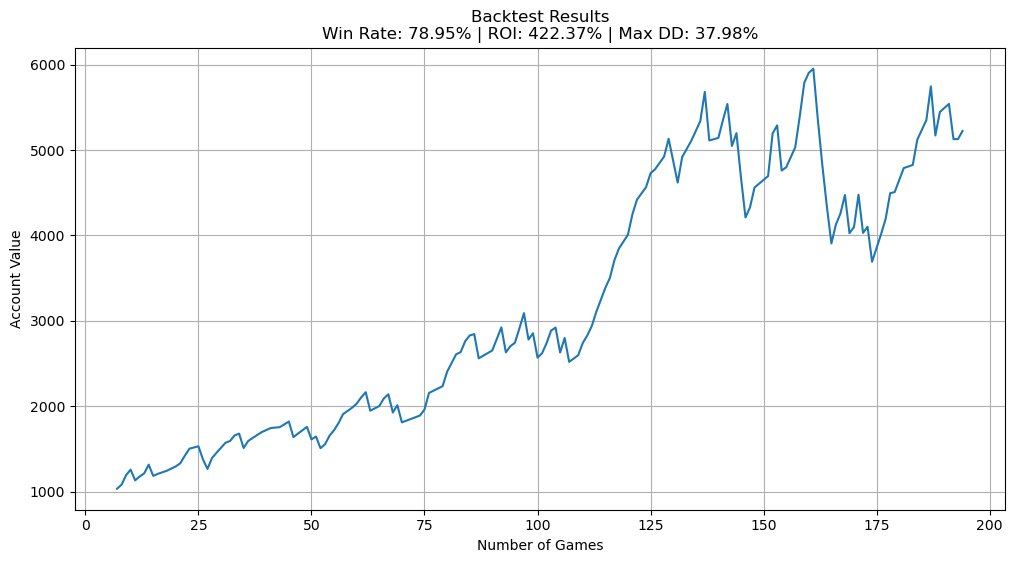

{'final_value': 5223.6585768418445,
 'roi': 4.223658576841845,
 'win_rate': 0.7894736842105263,
 'max_drawdown': 0.37979344685290845,
 'total_bets': 152}

In [18]:
# Make predictions for test data
# model = grid_search.best_estimator_
y_pred = model.predict(perf_conts)

nfl_utils.backtest_model(model, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0.0, show_plot=True, max_won_odds=2.1)

In [ ]:
# Make confusion matrix
cm = confusion_matrix(perf_y_col[:,0], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save XGBoost model

In [ ]:
model.save_model('xgboost_model.bin')